In [ ]:
import pandas as pd
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from scipy.stats import zscore
import leidenalg as la
np.random.seed(10)

%matplotlib inline

In [ ]:
def CreateLinkDf (count_matrix):
    count_matrix_turned = count_matrix.T
    #Calculate the Pearson Correlation
    correlation_matrix = count_matrix_turned.corr().to_numpy().round(decimals=3, out=None)
    #Removing self loops
    np.fill_diagonal(correlation_matrix, 0)
    #Covert the np matrix to padnas df
    df = pd.DataFrame(correlation_matrix, columns = list(count_matrix.index), index= list(count_matrix.index))
    #Define the edge list
    links = df.stack().reset_index()
    #Assign the column name as [source , target , value]
    links.columns = ["source" , "target" , "value"]
    return links

def DensityEvaluation (ths , links , verbose=1):
    density = []
    node_number = []
    edge_number = []
    average_degree = []
    if verbose:
        for th in ths :
            print("starting evaluatiom on {}".format(th))
            links_filtered=links.loc[ (links['value'] > th ) & (links['source'] != links['target']) ]
            print("rows removed")
            g = ig.Graph.TupleList(links_filtered.itertuples(index=False), directed=False, weights=True)
            print("netowrk loaded")
            density.append( g.density(loops=False))
            node_number.append( g.vcount())
            edge_number.append(g.ecount())
            average_degree.append(ig.mean(g.degree()))
            #delete all the nodes in the graph __> free space and avoid other problems
            to_delete_ids = [v.index for v in g.vs ]
            g.delete_vertices(to_delete_ids)
            print("memory cleaned")
            print("ended evaluatiom on {}".format(th))
    else :
        for th in ths :
            links_filtered=links.loc[ (links['value'] > th ) & (links['source'] != links['target']) ]
            g = ig.Graph.TupleList(links_filtered.itertuples(index=False), directed=False, weights=True)
            density.append( g.density(loops=False))
            node_number.append( g.vcount())
            edge_number.append(g.ecount())
            average_degree.append(ig.mean(g.degree()))
            #delete all the nodes in the graph __> free space and avoid other problems
            to_delete_ids = [v.index for v in g.vs ]
            g.delete_vertices(to_delete_ids)
    return density,node_number,edge_number, average_degree


def PlotDensity (ths, density,title) :
    fig = plt.figure(figsize=(7,5))
    color = 'tab:red'
    plt.set_title(title)
    plt.set_xlabel('tresholds')
    plt.set_ylabel('density', color=color)
    plt.plot(ths, density, color=color)
    plt.tick_params(axis='y', labelcolor=color)
    plt.show()


def genomic_position_stackbar (communities : list  , annotation_df : pd.DataFrame) : 
    final_annotation_df = pd.DataFrame()
    for num , community in enumerate(communities) :
        community_anontation = annotation_df.loc[list(communities)[num],:]
        community_anontation["community_numebr"] = "community_" + str(num)
        final_annotation_df = pd.concat([final_annotation_df  , community_anontation] , axis = 0 )

    return final_annotation_df


def transform_annotation_homer (path_file : str , filter_up = 0 , filter_down = 0) :
    annotation_gene = pd.read_csv(path_file,
                         delimiter="\t")
                         
    if filter_up != 0 :
        annotation_gene = annotation_gene.loc[(annotation_gene["Distance to TSS"] <= filter_up) & (annotation_gene["Distance to TSS"] >= filter_down) , :]

    annotation_gene = annotation_gene[["Chr","Start","End" ,'Annotation','Gene Name']]
    annotation_gene[['GenomicRegion', '_']] = annotation_gene.Annotation.str.split(" \\(", expand = True)
    annotation_gene['Start'] =  annotation_gene['Start'] -1
    annotation_gene["Sites"] = annotation_gene['Chr'].astype(str) +"-"+ annotation_gene["Start"].astype(str)+"-"+ annotation_gene["End"].astype(str)
    annotation_gene.drop( ['Chr','Start','End' , 'Annotation' , '_'] , axis = 1 , inplace=True)
    annotation_gene.set_index("Sites" , inplace=True)
    return annotation_gene


# Loading Communities
def loading_comminity_from_folder (path_file : str) :
    onlyfiles = [f for f in listdir(path_file)]
    communities = pd.DataFrame()
    for f in onlyfiles :
        df = pd.read_csv(path_file+f ,delimiter="\t" , names = ['chr','start','end'])
        df["sites"] = df['chr'].astype(str) +"-"+ df["start"].astype(str)+"-"+ df["end"].astype(str)
        
        df.drop(['chr','start','end'], axis  = 1 , inplace = True)
        df['community'] = f.split(".tsv")[0]
        communities = pd.concat([communities , df])
    return communities 



def set_node_community(G , communities) :
    '''Add community to node attributes'''
    for c , v_c in enumerate(communities) :
        for v in v_c :
            #Add 1 to save 0 for external edges
            G.nodes[v]['community']= c + 1

# Create Subgrphs for each community
def communities_subgraphs( G , communities) :
    subgraphs_list = []
    for community in communities :
       subgraphs_list.append(G.subgraph(community))
    return subgraphs_list


def plot_trends (communities_list : list , count_df : pd.DataFrame , dim_x : int , dim_y : int  , custom_ylim = (-2.5,10)) :
    x = 0
    community_number = 0
    fig, axes = plt.subplots(dim_x, dim_y , figsize=(30, 10) , dpi = 300 , constrained_layout=True)
    plt.setp(axes, ylim=custom_ylim)

    while x < dim_x :
        y = 0
        while y < dim_y  :
            #print (x,y,community_number)
            sns.violinplot(count_df.loc[communities_list[community_number],:] , ax = axes[x , y])
            axes[x,y].set_title(  'Community ' + str(community_number), fontstyle='italic')
            axes[x,y].set(xlabel=None)
            axes[x,y].set(ylabel="TMM")
            y = y+1

            community_number = community_number + 1 
            if community_number == len(communities_list) :
                break
        x = x + 1


def plot_trends_zscore (communities_list_toplot : list , count_df : pd.DataFrame , dim_x : int , dim_y : int , custom_ylim = (-2,2)) :
    count_df = count_df.apply(zscore , axis=1)

    x = 0
    community_number = 0
    fig, axes = plt.subplots(dim_x, dim_y , figsize=(30, 10) , dpi = 300 , constrained_layout=True)
    
    plt.setp(axes, ylim=custom_ylim)

    while x < dim_x :
        y = 0
        while y < dim_y  :
            #print (x,y,community_number)
            sns.lineplot(pd.melt(count_df.loc[communities_list_toplot[community_number],:]) , x = 'variable' , y = 'value' , ax = axes[x,y] , markers=True) #ax = axes[x,y] #
            axes[x,y].set_title(  'Community ' + str(community_number), fontstyle='italic') #x,
            axes[x,y].set(xlabel=None) #x,
            axes[x,y].set(ylabel="Z-score") #x,

            y = y+1

            community_number = community_number + 1 
            if community_number == len(communities_list_toplot) :
                break
        x = x + 1


def get_communities_names(G , communities) :
    communities_list_sp = []
    for n , community in enumerate(communities) :
        if len(community) > 100 :
            community_list = [G.vs[node_pos]["name"] for node_pos in community]
            communities_list_sp.append(community_list)

Loading Network

In [ ]:
network_path = 

In [ ]:
# Load Edge List 
e = pd.read_hdf( network_path)
e_df = e.reset_index()

In [ ]:
G = ig.Graph.TupleList(e_df.itertuples(index=False), directed=False, weights=None, edge_attrs = 'corr')

Create Cluster Tree

In [ ]:
cluster_tree_out_path = 

In [ ]:
for x in np.linspace(0.1 , 2.0 , 21) :
    communities = la.find_partition( G , la.RBConfigurationVertexPartition  , resolution_parameter = x , weights = 'corr' , seed = 1234 ) #la.RBConfigurationVertexPartition la.CPMVertexPartition
    if x == 0.1 :
        data = {
            "Node": range(len(G.vs)),
            "Cluster_0.1": communities.membership
        }
        cluster_table = pd.DataFrame(data)

    else :
        cluster_table[ "Cluster_" + str(x)] = communities.membership


In [ ]:
cluster_table.to_csv( cluster_tree_out_path , sep = "\t")

Check modularity

In [ ]:
resolution_values = np.arange(0.5, 2.6, 0.1)

modularity_scores = []
for x in list(resolution_values) :
    communities = la.find_partition( G , la.RBConfigurationVertexPartition  , resolution_parameter = x , weights = 'corr' , seed = 1234 )
    modularity = G.modularity(communities.membership)
    modularity_scores.append(modularity)

In [ ]:
# Plot modularity and resolution
sns.barplot(x=modularity_scores , y=list(resolution_values) , orient = "h" , color = 'black' )
# Label the axes
plt.xlabel("Modularity")
plt.ylabel("Resolution")

plt.show()

Finding Communities

In [ ]:
communities = la.find_partition( G , la.RBConfigurationVertexPartition  , resolution_parameter = 1.5 , weights = 'corr' , seed = 1234 ) # Change resolution_parameter for higher (e.g. 2) of lower resolution (e.g. 0.3 )

In [ ]:
for x in communities :
    if len(x) > 100 :
        print(len(x))

8814
8315
7341
6689
4872
4075
3340


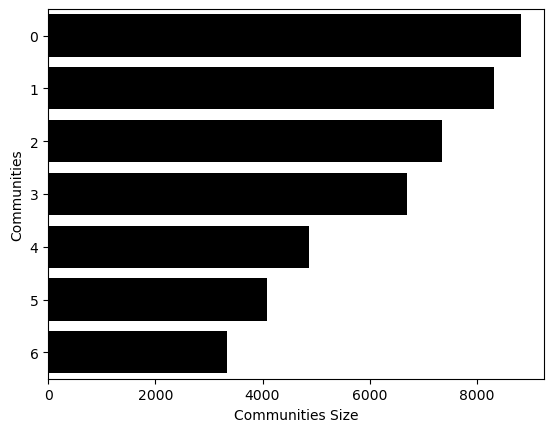

In [ ]:
# Example data
values =[ len(x) for x in communities if len(x)>100]

# Plot
sns.barplot(x=values , y=list(range(len(values))) , orient = "h" , color = 'black' )

# Label the axes
plt.xlabel("Communities Size")
plt.ylabel("Communities")

# plt.savefig("/mnt/nas-safu/analysis/PhDsdigiove/method_coAcces/data/CellReport/pictures/communities_size.png", format="png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

Plot Trends

In [ ]:
## Communities Spearman ROwnames
communities_list = get_communities_names(G , communities)

In [ ]:
counts_path = 

In [ ]:
data_matrix_df = pd.read_csv(counts_path , sep = "\t" , index_col = 0 )

plot_trends_zscore( communities_list , data_matrix_df , dim_y = 2 , dim_x=4 , custom_ylim=(-2 , 2))
# plt.savefig("/mnt/nas-safu/analysis/PhDsdigiove/method_coAcces/data/per_chr_norm/AllComm_allPeaks.png") 

Plot Annotations per community

In [ ]:
homer_annotation_path = 

In [ ]:
annotation = transform_annotation_homer(homer_annotation_path)
final_annotation = genomic_position_stackbar(communities_list, annotation)
plt.figure(figsize = (10 , 10 ))
#fig , ax = plt.subplots()
#fig.set_size_inches(18.5, 10.5)
final_annotation.groupby('community_numebr')['GenomicRegion'].value_counts(normalize=True).unstack('GenomicRegion').plot.bar(stacked=True ) 
plt.legend(loc = 'upper right' , bbox_to_anchor=(1.35, 0.75))

#plt.savefig('/mnt/nas-safu/analysis/PhDsdigiove/Vienna/Pictures/stacked_community.png', bbox_inches='tight' , dpi=300)